1. IMPORT LIBRARIES

In [9]:
#Import basic libraries 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import libraries for Model
from scipy import stats
import tensorflow as tf
from pylab import rcParams
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler

from keras import regularizers
from tensorflow.keras.regularizers import l2




2. UPLOADED DATASET

In [2]:
# 
data=pd.read_csv('dataset/creditcard_2023.csv')

In [3]:
data.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


3. PREPARING THE DATA

* The 'id' column is dropped as it is not going to use.
* Applying StandardScaler on the 'Amount' .

In [4]:
data = data.drop(['id'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

4. SPLITING THE DATA



In [5]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
X_train = X_train[X_train.Class == 0] #Filtering Training Data
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values


In [6]:
X_train.shape

(227565, 29)

5. BUILING THE MODEL

* Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. 
* The first two layers are used for the encoder, the last two go for the decoder.
*  Additionally, L1 regularization will be used during training

In [26]:
# Define the autoencoder
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

6. VISUALIZING EPOCHS

* Training the model for 100 epochs with a batch size of 32 samples 
* The ModelCheckpoint provided by Keras- Save the best performing model to a file.
* TensorBoard structured the training data, including metrics like loss, accuracy, and other details for read and visualization.
* History refers to the training history returned by the fit() method. It stores details about the model's performance during training and validation

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Hyperparameters
nb_epoch = 100
batch_size = 32

# Compile the autoencoder
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

# Callbacks
checkpointer = ModelCheckpoint(filepath="model.keras",
                               verbose=0,
                               save_best_only=True)

# Initialize TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=1,
                          write_graph=True,
                          write_images=True)

# Train the autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history


Epoch 1/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5588 - loss: 0.4182 - val_accuracy: 0.3728 - val_loss: 1.2206
Epoch 2/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5597 - loss: 0.4097 - val_accuracy: 0.3674 - val_loss: 1.2188
Epoch 3/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5605 - loss: 0.4065 - val_accuracy: 0.3705 - val_loss: 1.2375
Epoch 4/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5588 - loss: 0.3978 - val_accuracy: 0.3766 - val_loss: 1.2071
Epoch 5/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.5602 - loss: 0.4109 - val_accuracy: 0.3754 - val_loss: 1.1882
Epoch 6/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.5589 - loss: 0.4069 - val_accuracy: 0.3657 - val_loss: 1.2346
Epoch 7/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5582 - loss: 0.4018 - val_accuracy: 0.3810 - val_loss: 1.2263
Epoch 8/100
7112/7112 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5599 -

7. EVALUATION

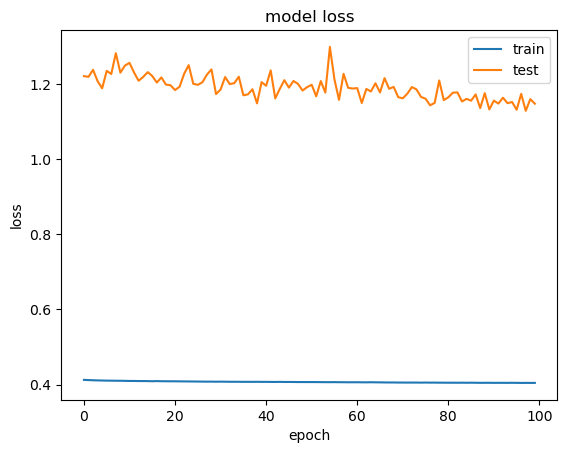

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

8. INTERPRETATION

* comparing reconstruction error values with the true class labels.

In [30]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


,reconstruction_error,true_class
count,113726.000000,113726.000000
mean,1.139105,0.500994
std,1.890226,0.500001
min,0.039982,0.000000
25%,0.265731,0.000000
50%,0.537229,1.000000
75%,1.259594,1.000000
max,163.466022,1.000000


Reconstruction error without fraud

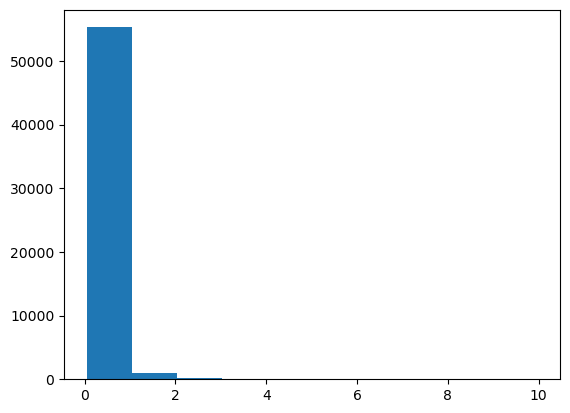

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)
plt.show()

Reconstruction error with fraud

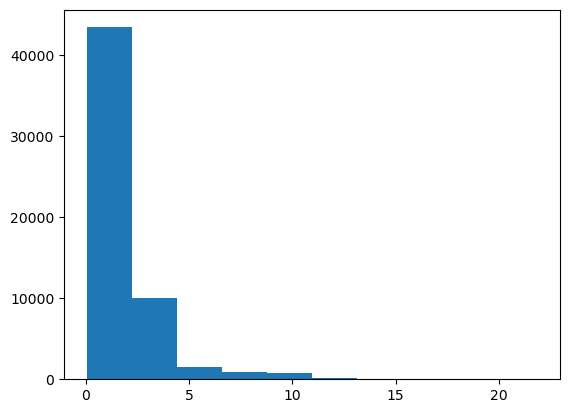

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)
plt.show()

In [33]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

9. Receiver Operating Characteristic (ROC) Curve

* ROC curves are very useful tool for understanding the performance of binary classifiers. 

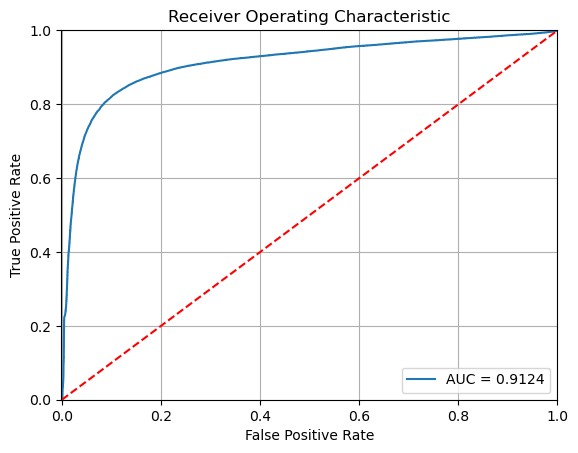

In [34]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

10. Precision vs Recall

Let’s take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let’s return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite - few returned results with very high relevancy. Ideally, you would want high precision and high recall - many results with that are highly relevant.

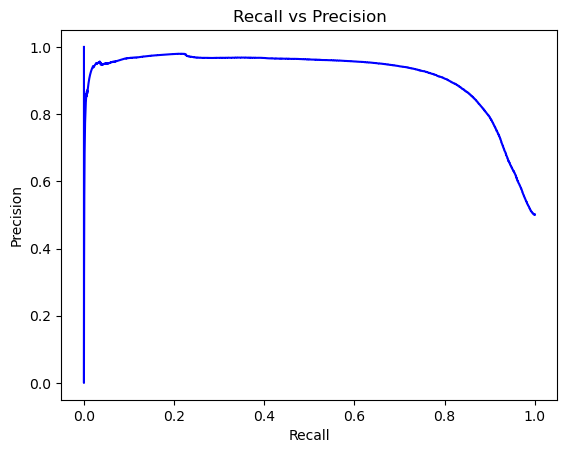

In [35]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Key Observations from the graph
* High Precision at Low Recall- This indicates that when the model makes only a few positive predictions, it is very accurate in those predictions.
* Stable Precision - This suggests that the model maintains high precision over a range of recall values, which is a good sign.

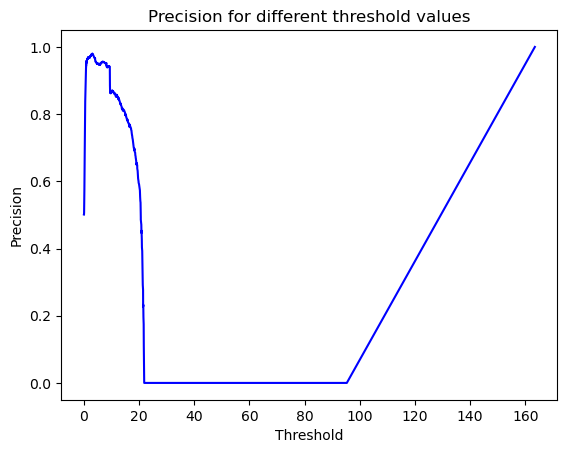

In [37]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

INSIGHTS

* High Precision at Low Thresholds: Initially, when the threshold values are low, the precision is high (close to 1). This means the model is very accurate when it makes positive predictions at low thresholds.

* Decrease in Precision: As the threshold increases, the precision decreases sharply and reaches 0 around a threshold value of 20. This implies that with higher thresholds, the number of false positives increases, reducing precision.

* Flat Section: Precision remains at 0 between threshold values of approximately 20 to 120. This indicates that within this range, the model struggles to make accurate positive predictions

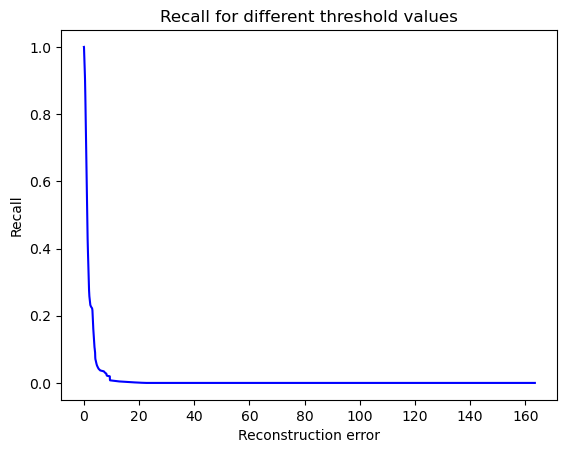

In [38]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

INSIGHTS

* High Recall at Low Reconstruction Error: At the left end of the graph, when the reconstruction error is low (around 0), the recall is high (close to 1.0). This indicates that the model is very effective at identifying positive instances when the reconstruction error threshold is low.

* Sharp Decrease in Recall: As the reconstruction error threshold increases, recall rapidly decreases. This implies that as the threshold for reconstruction error gets higher, the model starts missing more positive instances, resulting in lower recall.

* Flattening Near 0 Recall: After a certain point (around a reconstruction error of 30), recall flattens out near 0.0. This suggests that beyond this threshold, the model struggles significantly to detect positive instances.

11. PREDICTION

In [42]:
threshold = 2.9

12. Dividing the two types of transactions:



<Figure size 1200x1200 with 0 Axes>

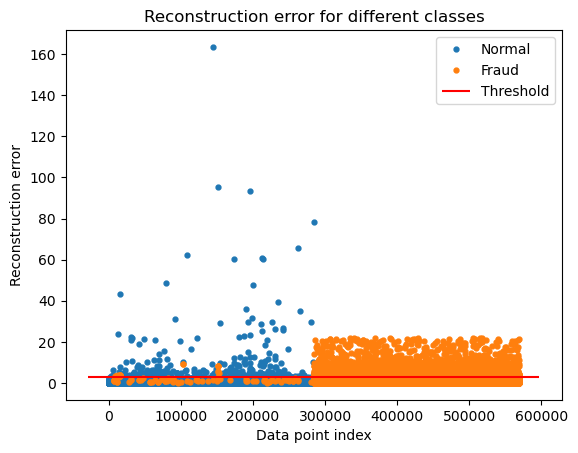

In [43]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

13. CONFUSION MATRIX

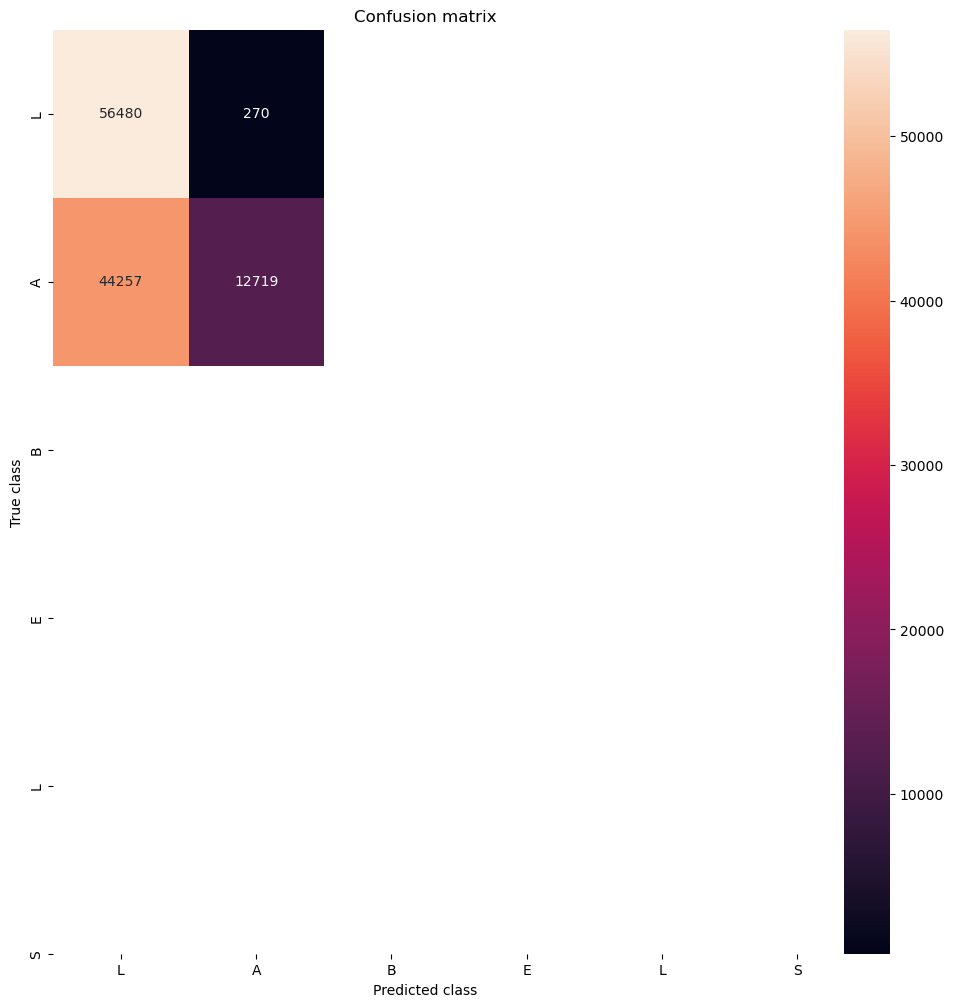

In [44]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels='LABELS', yticklabels='LABELS', annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

INSIGHT

* High Precision for Class "L": The model is very precise in predicting class "L", but it has a relatively low recall, indicating that it misses many actual "L" instances.

* High Recall for Class "A": The model is very good at identifying actual "A" instances but has a lower precision, meaning it predicts many false positives for class "A".